# Instalación de dependencias

In [1]:
# Monta Google Drive en Google Colab
from google.colab import drive
drive.mount('/content/drive')

print("Drive successfully mounted!")

# Navega a la carpeta donde está el archivo requirements.txt
print("Content on drive:")
%cd /content/drive/My Drive/modelo_anomalias
%ls -l
# Instala las dependencias desde el archivo requirements.txt
print("Installing dependencies...")
!pip install -r requirements.txt
print("Dependencies succesfully installed!")


Mounted at /content/drive
Drive successfully mounted!
Content on drive:
/content/drive/My Drive/modelo_anomalias
total 14964
drwx------ 2 root root   4096 Sep 22 00:59 2_hourly_data/
-rw------- 1 root root    926 Sep 22 00:59 data_consolid.py
-rw------- 1 root root   5754 Sep 22 00:59 data_get.py
-rw------- 1 root root   1697 Sep 22 00:59 data_transform.py
-rw------- 1 root root 784353 Sep 29 00:03 deteccion_anomalias_model_administrativas.ipynb
-rw------- 1 root root 152833 Sep 28 22:36 deteccion_anomalias_model_ahis.ipynb
-rw------- 1 root root 935443 Sep 27 18:37 deteccion_anomalias_model_alimentos_con_mazal.ipynb
-rw------- 1 root root 170773 Sep 28 19:53 deteccion_anomalias_model_big_bola.ipynb
-rw------- 1 root root 927888 Sep 28 01:44 deteccion_anomalias_model_compañia_operadora_ahis.ipynb
-rw------- 1 root root 876303 Sep 29 19:14 deteccion_anomalias_model_cv_directo.ipynb
-rw------- 1 root root 948026 Sep 28 17:38 deteccion_anomalias_model_entret_rio.ipynb
-rw------- 1 root r

# Library import

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import  mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
import math
from sklearn.metrics import mean_squared_error
import glob
import os


# Functions definitions

In [3]:

def create_features(df):
    """
    Create time series features from a datetime index.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the datetime index.

    Returns:
    pandas.DataFrame: A new DataFrame with added time series features.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Create a 'date' column and populate it with the datetime index
    df['date'] = df.index

    # Create an 'hour' column and populate it with the hour extracted from the 'date' column
    df['hour'] = df['date'].dt.hour

    # Create a 'dayofweek' column and populate it with the day of the week (0 = Monday, 6 = Sunday)
    df['dayofweek'] = df['date'].dt.dayofweek

    # Create a 'quarter' column and populate it with the quarter of the year
    df['quarter'] = df['date'].dt.quarter

    # Create a 'month' column and populate it with the month (1 = January, 12 = December)
    df['month'] = df['date'].dt.month

    # Create a 'year' column and populate it with the year as a 64-bit integer
    df['year'] = df['date'].dt.year.astype("int64")

    # Create a 'dayofyear' column and populate it with the day of the year
    df['dayofyear'] = df['date'].dt.dayofyear

    # Create a 'dayofmonth' column and populate it with the day of the month
    df['dayofmonth'] = df['date'].dt.day

    # Create a 'weekofyear' column and populate it with the week number of the year
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype("int64")

    return df


def create_lookback(dataset, look_back=14):
    """
    Crea un DataFrame extendido con datos pasados (look-back) como características.

    Esta función toma un DataFrame de datos de series temporales y crea un nuevo DataFrame
    con características que representan los valores pasados de la serie temporal.

    Parámetros:
    - dataset (DataFrame): El DataFrame de datos de series temporales, con una columna de valores temporales.
    - look_back (int): El número de períodos pasados que se utilizarán como características. Por defecto, es 14.

    Retorna:
    - DataFrame: Un nuevo DataFrame con características generadas a partir de los valores pasados.

    Ejemplo de uso:
    >>> df = pd.DataFrame({'tpv': [10, 15, 20, 25, 30, 35, 40]})
    >>> new_df = create_lookback(df, look_back=3)
    >>> print(new_df)
       tpv  3-day_tpv  2-day_tpv  1-day_tpv
    3   25         10         15         20
    4   30         15         20         25
    5   35         20         25         30
    6   40         25         30         35
    """
    # Genera nombres de columnas para las características basadas en look-back
    lb_names = [str(i) + "-day_tpv" for i in range(1, look_back + 1)]
    lb_names.reverse()  # Invierte el orden para que coincida con los días anteriores

    # Inicializa una lista para almacenar los valores de características
    vals = []

    # Recorre el DataFrame original y agrega los valores pasados como características
    for i in range(look_back, len(dataset)):
        a = dataset.iloc[(i - look_back):i, 0]  # Selecciona valores pasados
        vals.append(a.values)  # Agrega los valores como una lista

    # Crea un nuevo DataFrame con los valores pasados como características
    new_df = dataset.iloc[look_back:, :]  # Elimina las filas iniciales sin características
    df = pd.DataFrame(data=vals, columns=lb_names, index=new_df.index)  # Crea el DataFrame de características

    return new_df.join(df)  # Combina

# Data Load

## Monting files:

In [4]:
data = pd.read_csv("/content/drive/MyDrive/modelo_anomalias/2_hourly_data/full_2_hourly.csv", parse_dates = ['txn_date'], index_col = 'txn_date')
data.head()

,client,tpv
txn_date,,
2020-01-01,AMT170314IP0,108659.0
2020-01-01,CER060901G16,19500.0
2020-01-01,CJF941024F7A,173243.0
2020-01-01,IEA141216KQ1,49668.0
2020-01-01,JUM051123KYA,14098.0


In [5]:
#Listado de registros por cliente
data.client.value_counts()

SFA8706028C6    15507
AMT170314IP0    14074
PGG091023290    13035
OAH091124PR3    12919
CER060901G16    12403
IEA141216KQ1    12369
PIG930806GL1    12355
JUM051123KYA    12041
SDI121109B14    11042
PPA0708207I3    10695
NME101203MB9    10689
PJU190215RN2    10456
OJG130610HG2    10389
VSA180711KM6     8703
SCA070119MQ3     8212
CJF941024F7A     8002
MLS020424LM2     7963
OEB1410238K9     7669
CDJ2011111U4     5160
ANL171011549     3452
Name: client, dtype: int64

# Jumamex

In [6]:
data = data[data["client"] == 'JUM051123KYA']
data.head()

,client,tpv
txn_date,,
2020-01-01 00:00:00,JUM051123KYA,14098.0
2020-01-01 02:00:00,JUM051123KYA,10400.0
2020-01-01 04:00:00,JUM051123KYA,3200.0
2020-01-01 14:00:00,JUM051123KYA,3815.0
2020-01-01 16:00:00,JUM051123KYA,12084.0


In [7]:
data.tail()

,client,tpv
txn_date,,
2020-09-30 14:00:00,JUM051123KYA,23770.0
2020-09-30 16:00:00,JUM051123KYA,40800.0
2020-09-30 18:00:00,JUM051123KYA,35930.0
2020-09-30 20:00:00,JUM051123KYA,49276.0
2020-09-30 22:00:00,JUM051123KYA,76710.0


In [8]:
#Drop the column "client" which is useless
data.drop(["client"], axis = 1, inplace = True)
data.head()

<ipython-input-8-706567887833>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["client"], axis = 1, inplace = True)


,tpv
txn_date,
2020-01-01 00:00:00,14098.0
2020-01-01 02:00:00,10400.0
2020-01-01 04:00:00,3200.0
2020-01-01 14:00:00,3815.0
2020-01-01 16:00:00,12084.0


In [9]:
data_v1 = data.copy()
#creamos los features de fecha y lookback
data_v1 = create_features(data_v1)
data_v1 = data_v1.drop(columns=["hour","quarter"])
data_v1 = create_lookback(data_v1)

data_v1

,tpv,date,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,14-day_tpv,13-day_tpv,...,10-day_tpv,9-day_tpv,8-day_tpv,7-day_tpv,6-day_tpv,5-day_tpv,4-day_tpv,3-day_tpv,2-day_tpv,1-day_tpv
txn_date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 16:00:00,17800.0,2020-01-02 16:00:00,3,1,2020,2,2,1,14098.0,10400.0,...,12084.0,28259.0,66286.0,57907.0,57844.0,37597.0,490.0,2800.0,29173.0,19038.0
2020-01-02 18:00:00,51400.0,2020-01-02 18:00:00,3,1,2020,2,2,1,10400.0,3200.0,...,28259.0,66286.0,57907.0,57844.0,37597.0,490.0,2800.0,29173.0,19038.0,17800.0
2020-01-02 20:00:00,59530.0,2020-01-02 20:00:00,3,1,2020,2,2,1,3200.0,3815.0,...,66286.0,57907.0,57844.0,37597.0,490.0,2800.0,29173.0,19038.0,17800.0,51400.0
2020-01-02 22:00:00,112405.0,2020-01-02 22:00:00,3,1,2020,2,2,1,3815.0,12084.0,...,57907.0,57844.0,37597.0,490.0,2800.0,29173.0,19038.0,17800.0,51400.0,59530.0
2020-01-03 00:00:00,106298.0,2020-01-03 00:00:00,4,1,2020,3,3,1,12084.0,28259.0,...,57844.0,37597.0,490.0,2800.0,29173.0,19038.0,17800.0,51400.0,59530.0,112405.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 14:00:00,23770.0,2020-09-30 14:00:00,2,9,2020,274,30,40,21390.0,11340.0,...,7000.0,4916.0,109200.0,104300.0,34829.0,62735.0,32808.0,200.0,8600.0,29010.0
2020-09-30 16:00:00,40800.0,2020-09-30 16:00:00,2,9,2020,274,30,40,11340.0,10599.0,...,4916.0,109200.0,104300.0,34829.0,62735.0,32808.0,200.0,8600.0,29010.0,23770.0
2020-09-30 18:00:00,35930.0,2020-09-30 18:00:00,2,9,2020,274,30,40,10599.0,300.0,...,109200.0,104300.0,34829.0,62735.0,32808.0,200.0,8600.0,29010.0,23770.0,40800.0


In [10]:
data_v1.describe()

,tpv,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,14-day_tpv,13-day_tpv,12-day_tpv,...,10-day_tpv,9-day_tpv,8-day_tpv,7-day_tpv,6-day_tpv,5-day_tpv,4-day_tpv,3-day_tpv,2-day_tpv,1-day_tpv
count,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,...,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000,12027.000000
mean,49809.402176,3.022865,6.256922,2021.546936,174.912031,15.670242,25.411325,49786.944955,49786.181506,49794.396356,...,49805.381140,49809.592581,49809.970813,49804.476010,49800.376317,49797.978878,49796.829215,49800.180841,49802.935476,49804.606965
std,51572.788400,2.001553,3.417534,1.030237,104.512953,8.753333,14.947383,51572.871869,51573.468186,51575.062685,...,51574.182561,51573.170073,51573.028690,51574.793628,51576.109198,51576.405423,51576.831515,51574.936836,51573.311048,51572.968145
min,-9000.000000,0.000000,1.000000,2020.000000,1.000000,1.000000,1.000000,-9000.000000,-9000.000000,-9000.000000,...,-9000.000000,-9000.000000,-9000.000000,-9000.000000,-9000.000000,-9000.000000,-9000.000000,-9000.000000,-9000.000000,-9000.000000
25%,11990.000000,1.000000,3.000000,2021.000000,79.000000,8.000000,12.000000,11982.500000,11972.500000,11982.500000,...,11990.000000,11990.000000,11990.000000,11987.500000,11982.500000,11982.500000,11982.500000,11987.500000,11990.000000,11990.000000
50%,34945.000000,3.000000,6.000000,2022.000000,178.000000,16.000000,26.000000,34920.000000,34920.000000,34936.000000,...,34940.000000,34945.000000,34945.000000,34940.000000,34936.000000,34920.000000,34915.000000,34920.000000,34936.000000,34940.000000
75%,70795.000000,5.000000,9.000000,2022.000000,260.000000,23.000000,38.000000,70757.000000,70757.000000,70762.500000,...,70773.000000,70773.000000,70773.000000,70773.000000,70773.000000,70773.000000,70773.000000,70773.000000,70773.000000,70773.000000
max,597630.000000,6.000000,12.000000,2023.000000,366.000000,31.000000,53.000000,597630.000000,597630.000000,597630.000000,...,597630.000000,597630.000000,597630.000000,597630.000000,597630.000000,597630.000000,597630.000000,597630.000000,597630.000000,597630.000000


In [11]:
# delimitamos y separamos en train y test
# Definimos una fecha de inicio como '01-Enero-2020'
start_date = '01-January-2020'

# Filtramos los datos originales 'data_v1' para obtener solo las filas con índices mayores o iguales a
#  'start_date'.
# Luego, creamos una copia de estos datos filtrados en 'data_trim'.
data_trim = data_v1.loc[data_v1.index >= start_date].copy()

# Establecemos una fecha de separación como '01-Marzo-2023'
split_date = '01-March-2023'

# Filtramos los datos en 'data_trim' nuevamente, esta vez para obtener las filas con índices menores o iguales a 'split_date',
# lo que crea el conjunto de entrenamiento 'data_train'. Hacemos una copia de estos datos en 'data_train'.
data_train = data_trim.loc[data_trim.index <= split_date].copy()
print(f"Data for trining goes from {data_train.index[0]} to {data_train.index[-1]}")

# Filtramos 'data_trim' una vez más, pero esta vez para obtener las filas con índices mayores a 'split_date',
# creando así el conjunto de prueba 'data_test'. Hacemos una copia de estos datos en 'data_test'.
data_test = data_trim.loc[data_trim.index > split_date].copy()
print(f"Data for test goes from {data_test.index[0]} to {data_test.index[-1]}")


# A continuación, estamos dividiendo los datos en conjuntos de características (X) y
# etiquetas (y) tanto para el conjunto de entrenamiento como para el conjunto de prueba.

# Para el conjunto de entrenamiento, seleccionamos ciertas columnas como características en 'X_train' y la columna 'tpv' como etiquetas en 'y_train'.
X_train, y_train = data_train[["dayofweek", "dayofyear", "year", "14-day_tpv", "7-day_tpv", "1-day_tpv"]], data_train["tpv"]

# Para el conjunto de prueba, hacemos lo mismo que en el conjunto de entrenamiento,
# seleccionando las mismas columnas como características en 'X_test' y la columna 'tpv' como etiquetas en 'y_test'.
X_test, y_test = data_test[["dayofweek", "dayofyear", "year", "14-day_tpv", "7-day_tpv", "1-day_tpv"]], data_test["tpv"]

# También creamos otro conjunto de prueba 'X_test_2' y 'y_test_2' con las mismas características y etiquetas.
X_test_2, y_test_2 = data_test[["dayofweek", "dayofyear", "year", "14-day_tpv", "7-day_tpv", "1-day_tpv"]], data_test["tpv"]


Data for trining goes from 2020-01-02 16:00:00 to 2020-09-30 22:00:00
Data for test goes from 2023-03-01 02:00:00 to 2023-08-31 22:00:00


In [12]:


# Crear un objeto MinMaxScaler para estandarizar los datos en el rango [0, 1]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Estandarizar las características y etiquetas del conjunto de entrenamiento
data_train[["14-day_tpv", "7-day_tpv", "1-day_tpv", "tpv"]] = min_max_scaler.fit_transform(data_train[["14-day_tpv", "7-day_tpv", "1-day_tpv", "tpv"]])

# Estandarizar las características y etiquetas del conjunto de prueba
data_test[["14-day_tpv", "7-day_tpv", "1-day_tpv", "tpv"]] = min_max_scaler.transform(data_test[["14-day_tpv", "7-day_tpv", "1-day_tpv", "tpv"]])

# Crear conjuntos de características y etiquetas para el conjunto de entrenamiento
X_train, y_train = data_train[["14-day_tpv", "7-day_tpv", "1-day_tpv"]], data_train["tpv"]

# Crear conjuntos de características y etiquetas para el conjunto de prueba
X_test, y_test = data_test[["14-day_tpv", "7-day_tpv", "1-day_tpv"]], data_test["tpv"]


In [13]:
# Transformación de características para prepararlas para su uso en modelos de secuencia (red neuronal)

# Convertir las características de entrenamiento en un arreglo numpy
X_train = np.array(X_train)

# Cambiar la forma de las características de entrenamiento a un formato de secuencia (3D)
# donde la primera dimensión representa las muestras, la segunda dimensión es 1 y la tercera dimensión
# representa las características.
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# Convertir las características de prueba en un arreglo numpy
X_test = np.array(X_test)

# Cambiar la forma de las características de prueba a un formato de secuencia (3D)
# similar al conjunto de entrenamiento.
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Imprimir la longitud de las muestras en el conjunto de entrenamiento y prueba
print("Longitud de muestras en el conjunto de entrenamiento:", len(X_train))
print("Longitud de muestras en el conjunto de prueba:", len(X_test))



Longitud de muestras en el conjunto de entrenamiento: 10086
Longitud de muestras en el conjunto de prueba: 1941


In [14]:
"""
El código utiliza la biblioteca Keras (parte de TensorFlow) para construir un modelo de red neuronal secuencial.
Se agregan capas LSTM (Long Short-Term Memory), que son tipos de capas de redes neuronales recurrentes (RNN) diseñadas para trabajar
con datos secuenciales. Las capas LSTM tienen una cierta cantidad de unidades (neuronas) y devuelven secuencias de datos.
Se utiliza una capa de Dropout después de algunas capas LSTM. El Dropout es una técnica de regularización que ayuda a reducir
el sobreajuste al "apagar" aleatoriamente un porcentaje de neuronas durante el entrenamiento.
Esto ayuda a que el modelo generalice mejor a nuevos datos.

Finalmente, se agrega una capa densa (fully connected) con una única salida. Esta capa produce la predicción final del modelo. El modelo
se compila utilizando la función de pérdida "mean_squared_error" (error cuadrático medio) y el optimizador "adam".
Esto configura cómo se calculará la pérdida y cómo se actualizarán los pesos del modelo durante el entrenamiento.
Además agregué una semilla para que los resultados sean reproducibles.
"""

# Establecer una semilla para TensorFlow
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# Crear un modelo secuencial
model = Sequential()

# Agregar una capa LSTM con 90 unidades, tomando en cuenta la forma de entrada y devolviendo secuencias
model.add(LSTM(90, input_shape=(1, X_train.shape[2]), return_sequences=True))

# Agregar una segunda capa LSTM con 30 unidades, también devolviendo secuencias
model.add(LSTM(30, input_shape=(1, X_train.shape[2]), return_sequences=True))

# Agregar una capa de dropout para regularización, ayudando a prevenir el sobreajuste
model.add(Dropout(rate=0.1))

# Agregar una tercera capa LSTM con 15 unidades, devolviendo secuencias
model.add(LSTM(15, input_shape=(1, X_train.shape[2]), return_sequences=True))

# Agregar otra capa de dropout para regularización
model.add(Dropout(rate=0.05))

# Agregar una capa densa (fully connected) con una única salida (predicción)
model.add(Dense(1))

# Compilar el modelo utilizando el error cuadrático medio como función de pérdida y el optimizador Adam
model.compile(loss='mean_squared_error', optimizer='adam')


# Crear un directorio de registro para TensorBoard (puedes personalizar la ubicación)
log_dir = "logs/"

# Crear un callback de TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenar el modelo utilizando los datos de entrenamiento y  el callback de TensorBoard
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[tensorboard_callback])



Epoch 1/100
10086/10086 [==============================] - 87s 7ms/step - loss: 0.0060
Epoch 2/100
10086/10086 [==============================] - 63s 6ms/step - loss: 0.0056
Epoch 3/100
10086/10086 [==============================] - 63s 6ms/step - loss: 0.0055
Epoch 4/100
10086/10086 [==============================] - 61s 6ms/step - loss: 0.0054
Epoch 5/100
10086/10086 [==============================] - 61s 6ms/step - loss: 0.0055
Epoch 6/100
10086/10086 [==============================] - 60s 6ms/step - loss: 0.0054
Epoch 7/100
10086/10086 [==============================] - 62s 6ms/step - loss: 0.0054
Epoch 8/100
10086/10086 [==============================] - 61s 6ms/step - loss: 0.0054
Epoch 9/100
10086/10086 [==============================] - 61s 6ms/step - loss: 0.0053
Epoch 10/100
10086/10086 [==============================] - 60s 6ms/step - loss: 0.0053
Epoch 11/100
10086/10086 [==============================] - 59s 6ms/step - loss: 0.0053
Epoch 12/100
10086/10086 [===============

In [15]:
# Generar predicciones utilizando el modelo entrenado

# Predicciones para el conjunto de entrenamiento
# model.predict(X_train) devuelve un arreglo de predicciones para las muestras en X_train.
# El bucle [i[0][0] for i in model.predict(X_train)] extrae los valores de predicción de cada muestra.
# Luego, np.reshape(...) cambia la forma del arreglo resultante para que sea una columna única.
trainPredict = np.reshape([i[0][0] for i in model.predict(X_train)], (-1, 1))

# Predicciones para el conjunto de prueba
# Similar a las predicciones para el conjunto de entrenamiento, pero se aplica a X_test.
testPredict = np.reshape([i[0][0] for i in model.predict(X_test)], (-1, 1))


61/61 [==============================] - 0s 3ms/step


Test Score (RMSE): 0.02


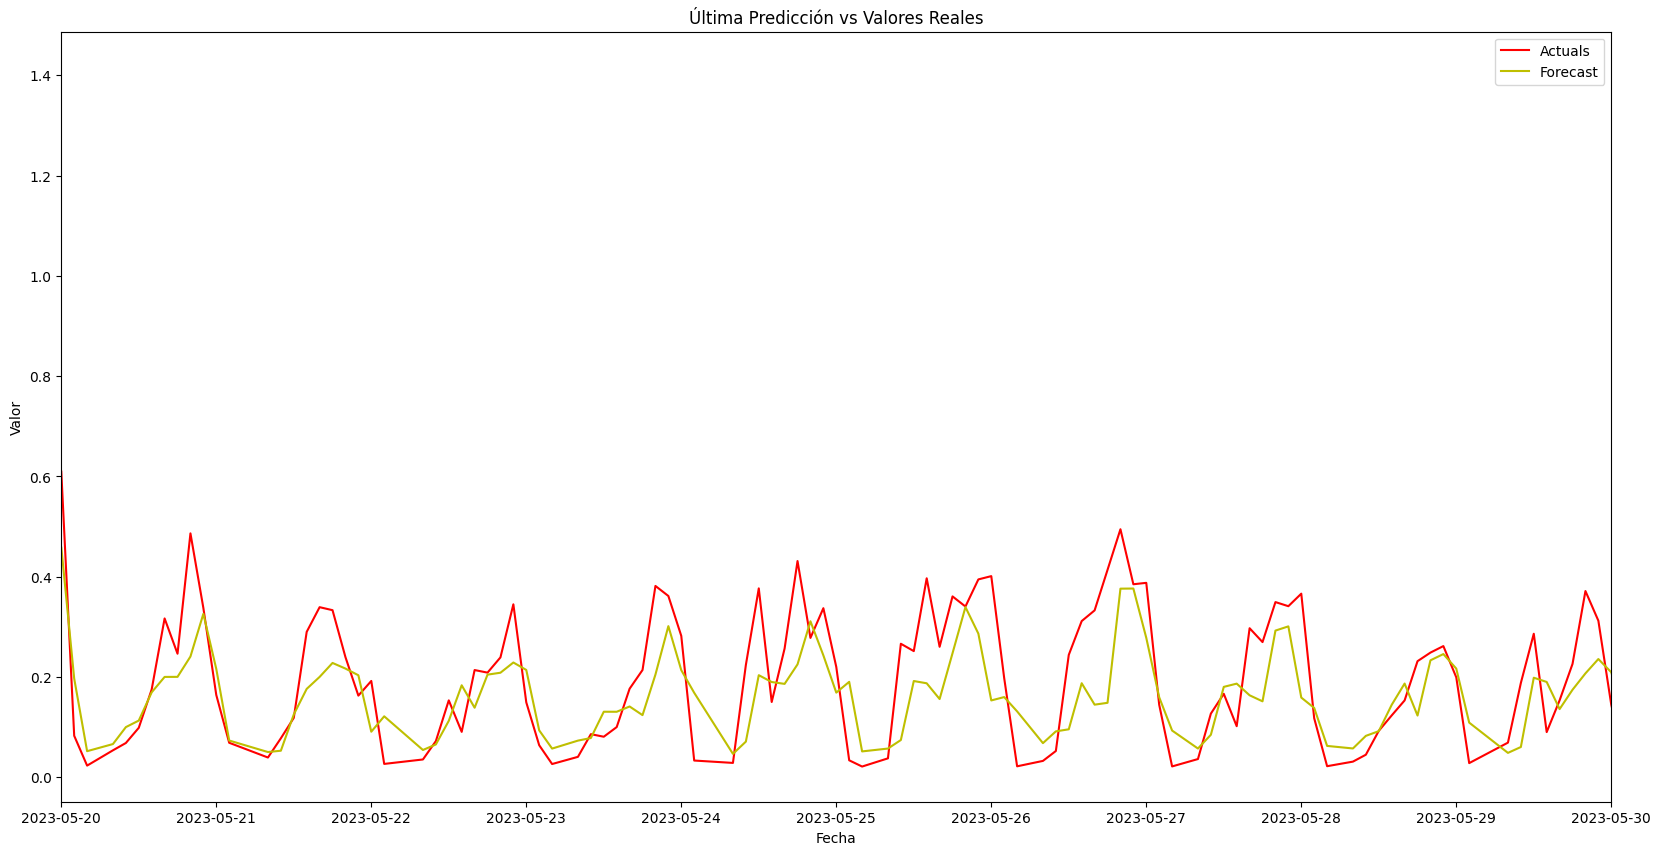

In [16]:


# Crear una figura y un eje para el gráfico
f, ax = plt.subplots(1, figsize=(20, 10))

# Plot y_test (valores reales) con etiqueta 'Actuals' en rojo (color='r')
ax.plot(data_test.index, y_test, color='r', label='Actuals')

# Plot testPredict (predicciones) con etiqueta 'Forecast' en amarillo (color='y')
ax.plot(data_test.index, testPredict, color='y', label='Forecast')

# Limitar el eje X al período de tiempo deseado
start_date = pd.to_datetime('2023-05-20', format='%Y-%m-%d')
end_date = pd.to_datetime('2023-05-30', format='%Y-%m-%d')
ax.set_xlim([start_date, end_date])

# Añadir un título al gráfico
plt.title('Última Predicción vs Valores Reales')

# Etiquetas de ejes
plt.xlabel('Fecha')
plt.ylabel('Valor')

# Mostrar una leyenda en el gráfico
plt.legend()

# Calcular el RMSE
rmse = mean_squared_error(y_test, testPredict)
print('Test Score (RMSE): %.2f' % rmse)
plt.show()


In [17]:
# Crear un DataFrame que contiene los resultados de las predicciones y las bandas de confianza

# Inicialmente, creamos un DataFrame 'd' con columnas para las predicciones y bandas de confianza
zero_data = np.zeros(shape=(X_test.shape[0], 4))
d = pd.DataFrame(zero_data, columns=["14-day_tpv", "7-day_tpv", "1-day_tpv", "tpv_predict"])


# Llenar la columna 'tpv_predict' con las predicciones del modelo
d["tpv_predict"] = testPredict  # No es necesario reshape aquí


# Invertir la escala de las predicciones para obtener los valores originales
d = min_max_scaler.inverse_transform(d)
print("Inverse transform")
d = pd.DataFrame(d, columns=["14-day_tpv", "7-day_tpv","1-day_tpv","tpv_predict"])
bandas = d.drop(columns = ["14-day_tpv", "7-day_tpv","1-day_tpv"])
# Crear un nuevo DataFrame 'bandas' para las bandas de confianza y los valores reales


# Calcular las bandas de confianza como la media más/menos una desviación estándar de las predicciones

std_dev = d["tpv_predict"].std()  # Calcular la desviación estándar
bandas["lim_inf"] = d["tpv_predict"] - std_dev
bandas["lim_sup"] = d["tpv_predict"] + std_dev



# Agregar los valores reales 'tpv_real' del conjunto de prueba
bandas["tpv_real"] = y_test_2.values

# Determinar si los valores reales están dentro de las bandas de confianza y crear la columna 'In'
bandas["In"] = bandas.apply(lambda row: True if (row.tpv_real >= row.lim_inf and row.tpv_real <= row.lim_sup) else False, axis=1)

# Establecer el índice del DataFrame 'bandas' para que coincida con las fechas del conjunto de prueba
bandas = bandas.set_index(data_test.index)

# Mostrar el DataFrame
bandas


Inverse transform


,tpv_predict,lim_inf,lim_sup,tpv_real,In
txn_date,,,,,
2023-03-01 02:00:00,24501.037889,-18382.618826,67384.694604,30595.0,True
2023-03-01 04:00:00,13627.774067,-29255.882648,56511.430782,700.0,True
2023-03-01 08:00:00,22653.175570,-20230.481145,65536.832285,8820.0,True
2023-03-01 10:00:00,30819.574875,-12064.081840,73703.231590,50832.0,True
2023-03-01 12:00:00,69998.220062,27114.563347,112881.876777,62230.0,True
...,...,...,...,...,...
2023-08-31 14:00:00,70907.853869,28024.197154,113791.510584,100018.1,True
2023-08-31 16:00:00,71439.559114,28555.902399,114323.215829,157070.0,False
2023-08-31 18:00:00,109433.461672,66549.804957,152317.118387,170625.0,False


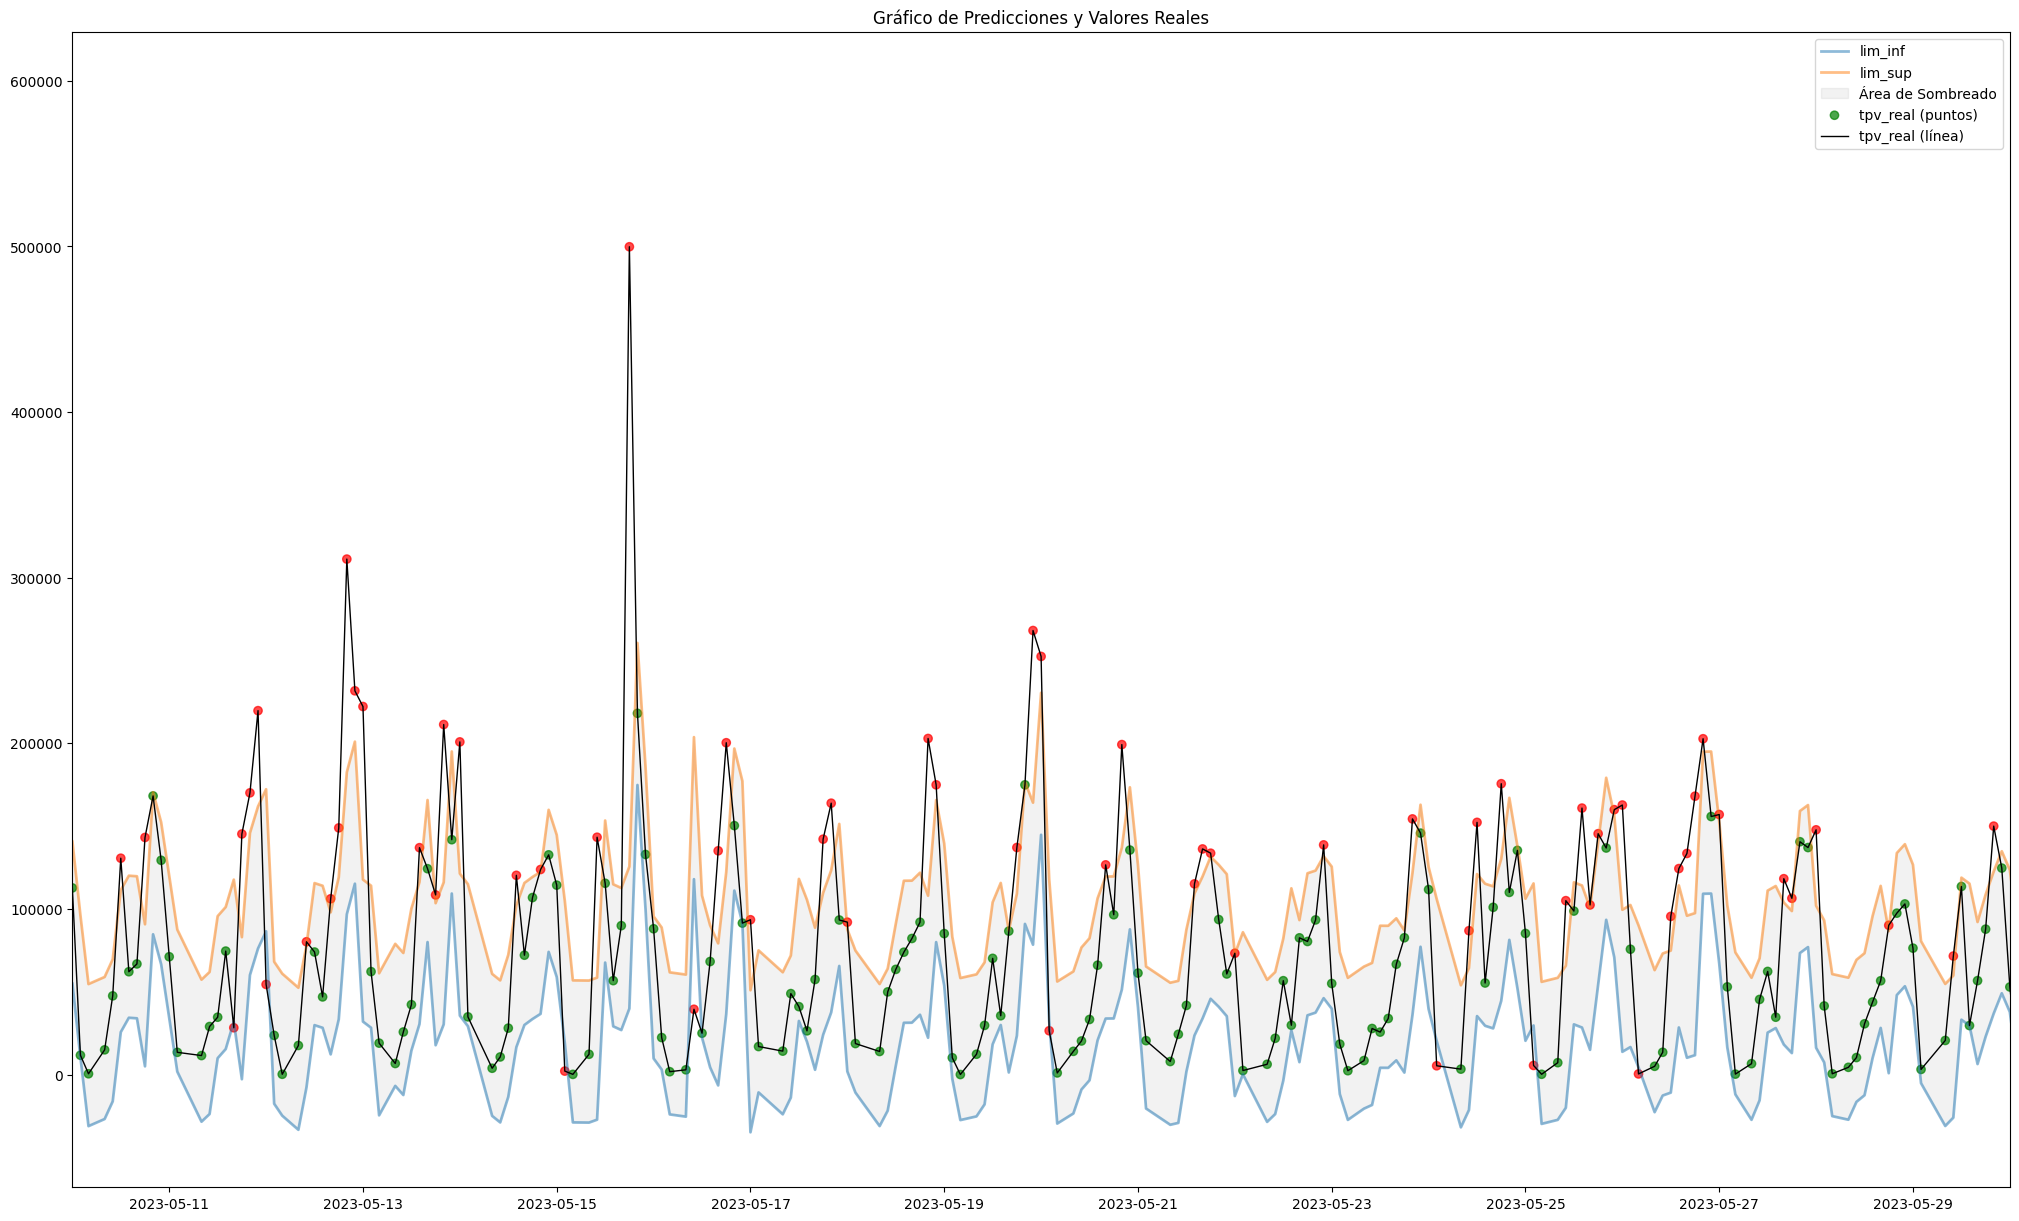

In [18]:
import matplotlib.pyplot as plt

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(25, 15))

# Graficar lim_inf y lim_sup con transparencia y grosor de línea
ax.plot(bandas.index, bandas["lim_inf"], label='lim_inf', linestyle='-', alpha=0.5, linewidth=2)
ax.plot(bandas.index, bandas["lim_sup"], label='lim_sup', linestyle='-', alpha=0.5, linewidth=2)

# Graficar el área de sombreado entre lim_inf y lim_sup
ax.fill_between(bandas.index, bandas["lim_inf"], bandas["lim_sup"], color='gray', alpha=0.1, label='Área de Sombreado')

# Graficar tpv_predict como una línea punteada con transparencia
#ax.plot(bandas.index, bandas["tpv_predict"], label='tpv_predict', linestyle='--', alpha=0.5)

# Graficar tpv_real como puntos en diferentes colores
ax.scatter(bandas.index, bandas["tpv_real"], c=bandas["In"].map({True: 'green', False: 'red'}),
           label='tpv_real (puntos)', alpha=0.7)

# Graficar tpv_real como una línea negra delgada
ax.plot(bandas.index, bandas["tpv_real"], label='tpv_real (línea)', color='black', linewidth=1)

# Limitar el eje X al período de tiempo deseado
start_date = pd.to_datetime('2023-05-10', format='%Y-%m-%d')
end_date = pd.to_datetime('2023-05-30', format='%Y-%m-%d')
ax.set_xlim([start_date, end_date])

# Configurar título y leyenda
plt.title('Gráfico de Predicciones y Valores Reales')
plt.legend()

# Mostrar el gráfico
plt.show()


In [19]:
print(bandas.In.value_counts())
print(bandas["In"].sum() / bandas["In"].count() *100)

True     1374
False     567
Name: In, dtype: int64
70.78825347758887


In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Supongamos que tienes un modelo llamado 'model' ya entrenado y listo para guardar

# Guarda el modelo completo en un archivo HDF5
model.save("model_jumamex.h5")
print("Modelo guardado éxitosamente.")

# Cargamos el modelo desde el archivo HDF5
modelo_cargado = load_model("model_jumamex.h5")
print("Modelo cargado éxitosamente.")

Modelo guardado éxitosamente.
Modelo cargado éxitosamente.
